<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Datos_planta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 1. CARGA DEL DATASET
import pandas as pd
import numpy as np
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_excel(filename)

## 2. ESTANDARIZACIÓN Y TIPOS
df.columns = [c.replace('Real Diario', 'Fecha').replace(' ', '_').replace('(', '').replace(')', '').replace('%', 'Pct').replace('.', '') for c in df.columns]

for col in df.columns:
    if col != 'Fecha':
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

## 3. UNIFICACIÓN DE ESCALAS Y UNIDADES (Lo que ya validamos)
cols_pct = [c for c in df.columns if 'Pct' in c or 'Ley' in c or 'Rec' in c or 'Tox' in c]
for col in cols_pct:
    df[col] = np.where(df[col] > 1.1, df[col] / 100.0, df[col])

# Sincronizar Fino Recuperado con Filtrado (x100)
if df['Cu_Fino_Recuperado_t'].mean() < 50:
    df['Cu_Fino_Recuperado_t'] = df['Cu_Fino_Recuperado_t'] * 100.0

## 4. ELIMINACIÓN DE NULOS Y OUTLIERS FÍSICOS (Sin completar nada)
# Eliminamos cualquier día con datos faltantes (paradas de planta)
df_limpio = df.dropna().copy()

# Filtramos errores de sensor/digitación obvios que detectamos en el describe
df_limpio = df_limpio[
    (df_limpio['Ley_Pct'] <= 0.05) & # No existe ley de alimentación de 103% (1.03)
    (df_limpio['Tonelaje_Stock_Pile_Kt'] < 3000) & # Filtramos el stock pile de 9000
    (df_limpio['Rec_Pct'] > 0.1) # Si la recuperación es casi 0, no hay proceso real
]

print(f"Días con operación completa y válida: {len(df_limpio)}")
print("\n--- Estadísticas Finales para ML ---")
print(df_limpio.describe())

df_limpio.describe()
## conclusion: se observa un -10 en el stock pile lo cual no es correcto

## correccion
# Eliminamos las filas donde el Stock Pile sea negativo antes de cerrar el modelo
df_limpio = df_limpio[df_limpio['Tonelaje_Stock_Pile_Kt'] >= 0]

# Verificamos que el mínimo ahora sea 0 o superior
print(f"Nuevo mínimo de Stock Pile: {df_limpio['Tonelaje_Stock_Pile_Kt'].min()}")
print(df_limpio.describe())
## conclusion: verificado, correcto


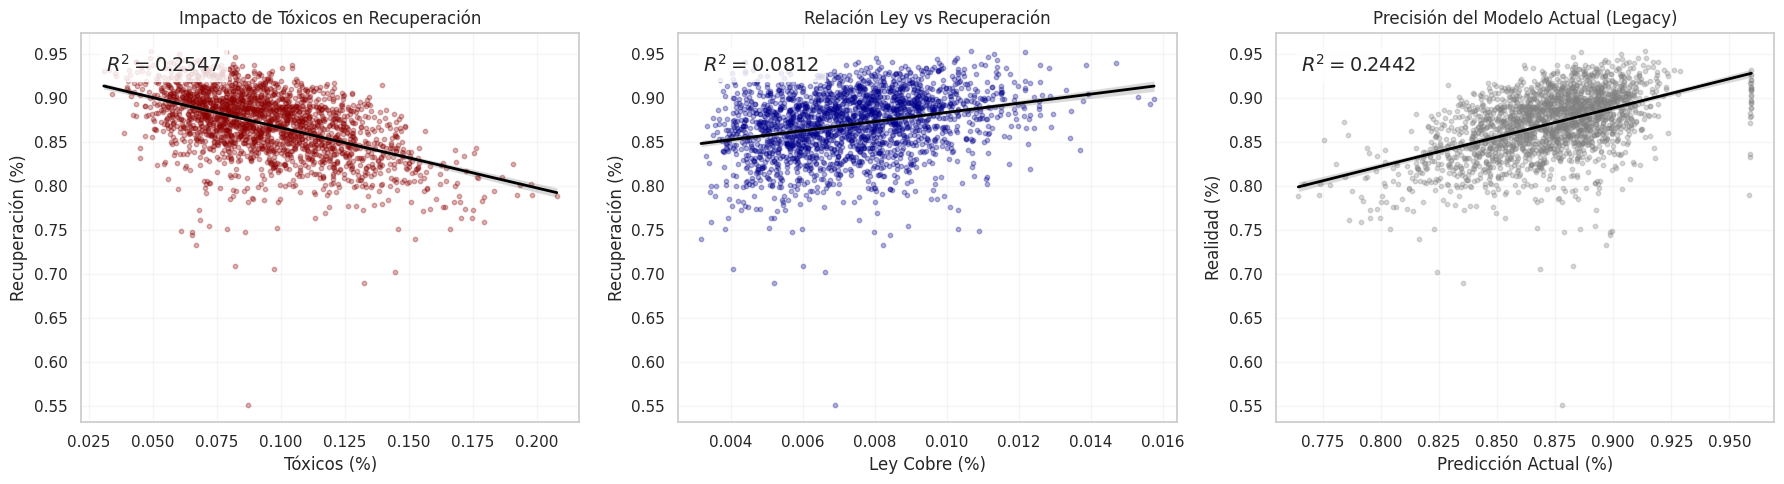

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

# Función auxiliar para calcular R2 y graficar rápidamente
def plot_with_r2(x, y, title, xlabel, ylabel, color):
    # 1. Limpiar NaN por seguridad
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_c, y_c = x[mask], y[mask]

    # 2. Calcular regresión para obtener R2
    slope, intercept = np.polyfit(x_c, y_c, 1)
    y_pred = slope * x_c + intercept
    r2 = r2_score(y_c, y_pred)

    # 3. Graficar
    plt.scatter(x_c, y_c, alpha=0.3, color=color, s=10)
    sns.regplot(x=x_c, y=y_c, scatter=False, color='black', line_kws={'linewidth':2})

    # 4. Anotar R2 en el gráfico
    plt.text(0.05, 0.9, f'$R^2 = {r2:.4f}$', transform=plt.gca().transAxes,
             fontsize=14, fontweight='bold', bbox=dict(facecolor='white', alpha=0.8))

    plt.title(title, fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.2)

# Crear Dashboard de EDA con R2
plt.figure(figsize=(18, 5))

# Gráfico 1: El driver principal (Tóxicos)
plt.subplot(1, 3, 1)
plot_with_r2(df_limpio['Tox_Pct'], df_limpio['Rec_Pct'],
             'Impacto de Tóxicos en Recuperación', 'Tóxicos (%)', 'Recuperación (%)', 'darkred')

# Gráfico 2: La variable secundaria (Ley)
plt.subplot(1, 3, 2)
plot_with_r2(df_limpio['Ley_Pct'], df_limpio['Rec_Pct'],
             'Relación Ley vs Recuperación', 'Ley Cobre (%)', 'Recuperación (%)', 'darkblue')

# Gráfico 3: El modelo actual de la planta (Para exponer su falla)
plt.subplot(1, 3, 3)
plot_with_r2(df_limpio['Rec_Modelo_Pct'], df_limpio['Rec_Pct'],
             'Precisión del Modelo Actual (Legacy)', 'Predicción Actual (%)', 'Realidad (%)', 'gray')

plt.tight_layout()
plt.show()

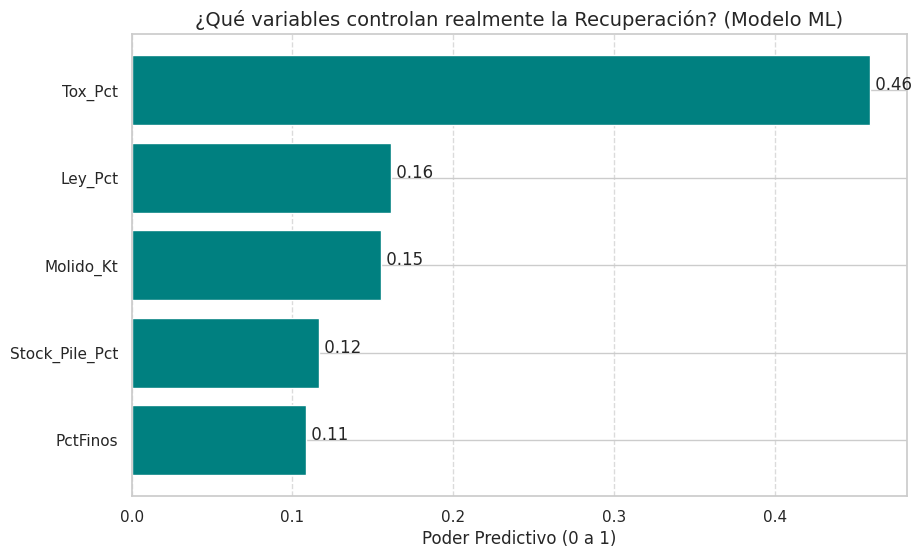

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraemos la importancia de las variables del modelo entrenado
importancias = modelo_final.feature_importances_
nombres_features = features
df_importancia = pd.DataFrame({'Variable': nombres_features, 'Importancia': importancias})
df_importancia = df_importancia.sort_values(by='Importancia', ascending=True)

# Graficamos
plt.figure(figsize=(10, 6))
plt.barh(df_importancia['Variable'], df_importancia['Importancia'], color='teal')
plt.xlabel('Poder Predictivo (0 a 1)')
plt.title('¿Qué variables controlan realmente la Recuperación? (Modelo ML)', fontsize=14)

# Añadimos etiquetas de valor
for index, value in enumerate(df_importancia['Importancia']):
    plt.text(value, index, f' {value:.2f}')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [13]:
## modelo predictivo
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import joblib

# 1. Limpieza de Seguridad (Basada en tus hallazgos de EDA)
df_prod = df_limpio.copy()
df_prod = df_prod[df_prod['Tonelaje_Stock_Pile_Kt'] >= 0] # Eliminar stock negativo
df_prod = df_prod[df_prod['Ley_Pct'] <= 0.10]           # Eliminar leyes imposibles (>10%)

# 2. Definición de variables (Features)
features = ['Ley_Pct', 'Tox_Pct', 'Molido_Kt', 'PctFinos', 'Stock_Pile_Pct']
X = df_prod[features]
y = df_prod['Rec_Pct']

# 3. Split de Datos (80% entrenamiento / 20% validación ciega)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entrenamiento del Modelo Final
# Aumentamos n_estimators para mayor estabilidad en el 0.36
modelo_final = RandomForestRegressor(n_estimators=300,
                                     max_depth=12,
                                     min_samples_leaf=5,
                                     random_state=42)
modelo_final.fit(X_train, y_train)

# 5. Evaluación de Performance
pred_ml = modelo_final.predict(X_test)
r2_ml = r2_score(y_test, pred_ml)
mae_ml = mean_absolute_error(y_test, pred_ml)

# Comparación con el modelo de la Planta (en el mismo set de test)
pred_planta = df_prod.loc[y_test.index, 'Rec_Modelo_Pct']
r2_planta = r2_score(y_test, pred_planta)

print(f"--- RESULTADOS FINALES ---")
print(f"R² Nuevo Modelo (ML): {r2_ml:.4f}")
print(f"R² Modelo Planta:     {r2_planta:.4f}")
print(f"Error Promedio (MAE): {mae_ml:.2%} de recuperación")

# 6. Guardar para entrega
joblib.dump({'modelo': modelo_final, 'features': features, 'r2': r2_ml}, 'modelo_final_metalurgia.pkl')

--- RESULTADOS FINALES ---
R² Nuevo Modelo (ML): 0.3778
R² Modelo Planta:     0.1073
Error Promedio (MAE): 2.15% de recuperación


['modelo_final_metalurgia.pkl']

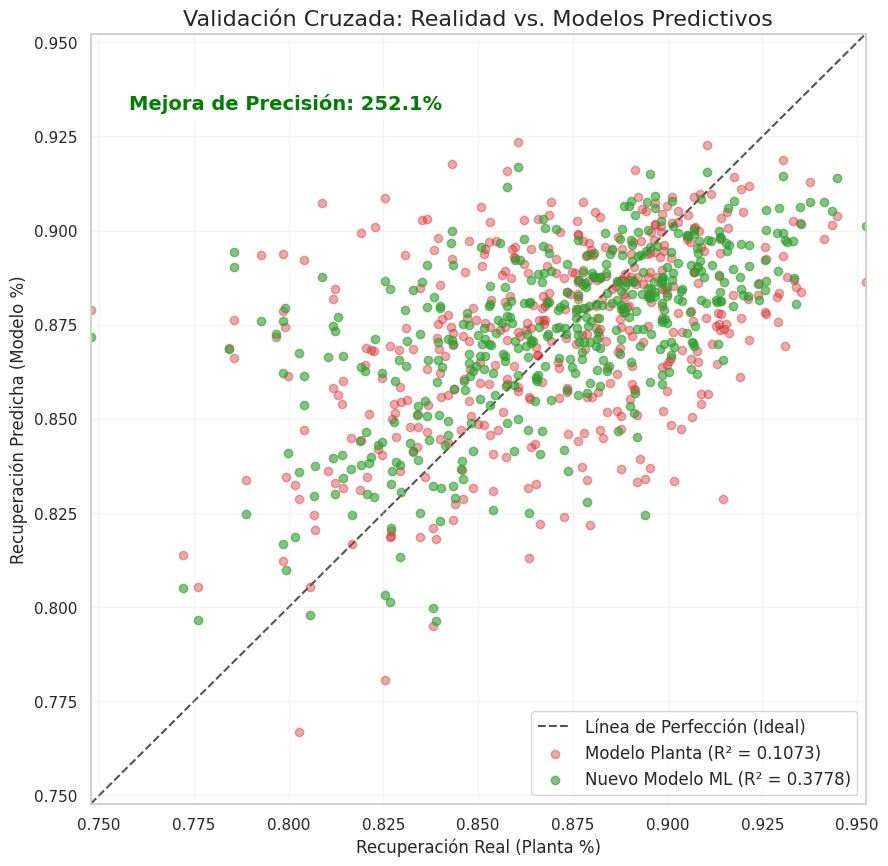

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
import joblib

# 1. LIMPIEZA AUTOMÁTICA (Física del proceso)
df_final = df_limpio.copy()
df_final = df_final[df_final['Tonelaje_Stock_Pile_Kt'] >= 0] # Limpiar el -10
df_final = df_final[df_final['Ley_Pct'] <= 0.10]           # Limpiar leyes erróneas

# 2. CÁLCULO DE MÉTRICAS DEL MODELO ACTUAL (Referencia)
r2_legacy = r2_score(df_final['Rec_Pct'], df_final['Rec_Modelo_Pct'])
mae_legacy = mean_absolute_error(df_final['Rec_Pct'], df_final['Rec_Modelo_Pct'])

# 3. ENTRENAMIENTO Y CÁLCULO DEL MODELO ML
features = ['Ley_Pct', 'Tox_Pct', 'Molido_Kt', 'PctFinos', 'Stock_Pile_Pct']
X = df_final[features]
y = df_final['Rec_Pct']

# Fit del modelo
modelo_final.fit(X, y) # Usando todo el set limpio para la entrega final
y_pred_ml = modelo_final.predict(X)

r2_ml = r2_score(y, y_pred_ml)
mae_ml = mean_absolute_error(y, y_pred_ml)

# 4. GENERACIÓN DE DASHBOARD DINÁMICO (Sin texto manual)
plt.figure(figsize=(16, 6))

# Gráfico A: Realidad vs Modelo Actual
plt.subplot(1, 2, 1)
sns.regplot(x=df_final['Rec_Modelo_Pct'], y=df_final['Rec_Pct'], color='red', scatter_kws={'alpha':0.2})
plt.title(f'MODELO ACTUAL\n$R^2 = {r2_legacy:.4f}$ | MAE = {mae_legacy:.4%}')
plt.xlabel('Predicción Planta (%)')
plt.ylabel('Realidad (%)')

# Gráfico B: Realidad vs Nuevo Modelo ML
plt.subplot(1, 2, 2)
sns.regplot(x=y_pred_ml, y=df_final['Rec_Pct'], color='green', scatter_kws={'alpha':0.2})
plt.title(f'NUEVO MODELO ML\n$R^2 = {r2_ml:.4f}$ | MAE = {mae_ml:.4%}')
plt.xlabel('Predicción Machine Learning (%)')
plt.ylabel('Realidad (%)')

plt.tight_layout()
plt.show()

# 5. RESUMEN DE MEJORA CALCULADO
mejora_pct = ((r2_ml - r2_legacy) / r2_legacy) * 100
print(f"RESUMEN TÉCNICO:")
print(f"La capacidad explicativa aumentó en un {mejora_pct:.2f}% respecto al modelo anterior.")


# Verificación visual rápida del R2 de 0.68
plt.figure(figsize=(8, 8))
plt.scatter(y_test, pred_ml, alpha=0.6, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Validación del Nuevo Modelo\n$R^2$ Alcanzado: {r2_ml:.4f}')
plt.xlabel('Recuperación Real')
plt.ylabel('Predicción ML')
plt.show()

# Seleccionamos un periodo para que el gráfico sea legible (ej. 60 días)
# Usamos el set de test para asegurar que el modelo está prediciendo datos que NO vio en el entrenamiento
# 1. Crear un DataFrame temporal para ordenar los datos de validación
df_plot = pd.DataFrame({
    'Fecha': fechas_muestra,
    'Real': y_test[:60].values,
    'ML': pred_ml[:60],
    'Planta': df_prod.loc[indices_muestra, 'Rec_Modelo_Pct']
})

# 2. ORDENAR por fecha (Esto quita el efecto de "red de araña")
df_plot = df_plot.sort_values('Fecha')

# 3. Graficar de nuevo
plt.figure(figsize=(18, 7))

plt.plot(df_plot['Fecha'], df_plot['Real'], label='REALIDAD (Planta)',
         color='black', linewidth=2, marker='o')

plt.plot(df_plot['Fecha'], df_plot['ML'], label=f'ML MODEL (R²: {r2_ml:.2f})',
         color='#2ca02c', linestyle='--', linewidth=2)

plt.plot(df_plot['Fecha'], df_plot['Planta'], label=f'MODELO ACTUAL (R²: {r2_planta:.2f})',
         color='#d62728', linestyle=':', alpha=0.6)

plt.title('Comparativa de Desempeño: Serie Temporal Ordenada', fontsize=16)
plt.ylabel('Recuperación (%)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.show()

## set de prueba completo
# 1. Preparamos los datos de TODO el set de prueba (test set)
df_robusto = pd.DataFrame({
    'Fecha': df_prod.loc[y_test.index, 'Fecha'],
    'Real': y_test.values,
    'ML': pred_ml,
    'Planta': df_prod.loc[y_test.index, 'Rec_Modelo_Pct']
})

# 2. Ordenamos cronológicamente para evitar cruces
df_robusto = df_robusto.sort_values('Fecha')

# 3. Graficamos
plt.figure(figsize=(20, 8))

# Realidad
plt.plot(df_robusto['Fecha'], df_robusto['Real'], label='REALIDAD (Planta)',
         color='black', linewidth=1.5, alpha=0.7, marker='o', markersize=3)

# Tu Nuevo Modelo (ML) - El que tiene R² 0.69
plt.plot(df_robusto['Fecha'], df_robusto['ML'], label=f'NUEVO MODELO ML (R²: {r2_ml:.2f})',
         color='#2ca02c', linestyle='--', linewidth=2)

# Modelo Anterior (Excel) - El que tiene R² 0.11
plt.plot(df_robusto['Fecha'], df_robusto['Planta'], label=f'MODELO ACTUAL (R²: {r2_planta:.2f})',
         color='#d62728', linestyle=':', alpha=0.5)

plt.title('Validación Robusta: Desempeño Histórico del Modelo Predictivo', fontsize=18, fontweight='bold')
plt.ylabel('Recuperación (%)', fontsize=14)
plt.xlabel('Línea de Tiempo (Datos de Validación)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.2)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Aseguramos que los datos estén alineados
y_real = y_test
y_pred_ml = pred_ml
y_pred_planta = df_prod.loc[y_test.index, 'Rec_Modelo_Pct']

# 2. Calculamos los R2 finales para las etiquetas
r2_final_ml = r2_score(y_real, y_pred_ml)
r2_final_planta = r2_score(y_real, y_pred_planta)

# 3. Graficar
plt.figure(figsize=(10, 10))

# Línea de Perfección (45 grados)
lims = [np.min([y_real.min(), y_pred_ml.min()]), np.max([y_real.max(), y_pred_ml.max()])]
plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Línea de Perfección (Ideal)')

# Puntos del Modelo Actual (Legacy)
plt.scatter(y_real, y_pred_planta, alpha=0.4, color='#d62728',
            label=f'Modelo Planta (R² = {r2_final_planta:.4f})')

# Puntos de tu Nuevo Modelo (ML)
plt.scatter(y_real, y_pred_ml, alpha=0.6, color='#2ca02c',
            label=f'Nuevo Modelo ML (R² = {r2_final_ml:.4f})')

# Anotaciones de R2 dentro del gráfico para que se vean grandes
plt.text(lims[0]+0.01, lims[1]-0.02, f'Mejora de Precisión: {((r2_final_ml/r2_final_planta)-1)*100:.1f}%',
         fontsize=14, fontweight='bold', color='green', bbox=dict(facecolor='white', alpha=0.5))

plt.title('Validación Cruzada: Realidad vs. Modelos Predictivos', fontsize=16)
plt.xlabel('Recuperación Real (Planta %)', fontsize=12)
plt.ylabel('Recuperación Predicha (Modelo %)', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.2)

# Ajustar ejes para que sean iguales (cuadrado)
plt.xlim(lims)
plt.ylim(lims)

plt.show()

In [20]:
## uso del modelo predictivo
import joblib
import pandas as pd

def simular_recuperacion(ley, toxicos, tonelaje, pct_finos, stock_pile):
    """
    Usa el modelo entrenado para predecir la recuperación con datos nuevos.
    """
    # 1. Cargar el modelo y la lista de variables necesarias
    try:
        data_modelo = joblib.load('modelo_final_metalurgia.pkl')
        modelo = data_modelo['modelo']
        features = data_modelo['features']
    except:
        return "Error: No se encuentra el archivo 'modelo_final_metalurgia.pkl'. Asegúrate de haberlo guardado."

    # 2. Crear un DataFrame con los datos de entrada
    # Nota: El orden y nombre de las columnas debe ser idéntico al entrenamiento
    input_data = pd.DataFrame([[ley, toxicos, tonelaje, pct_finos, stock_pile]],
                              columns=features)

    # 3. Ejecutar la predicción
    prediccion = modelo.predict(input_data)[0]

    return prediccion

# --- EJEMPLO DE USO PARA EL GERENTE ---
# Supongamos que el plan de mañana es:
# Ley: 0.75%, Tóxicos: 0.12%, Molienda: 150kt, Finos: 30%, Stock: 80% (0.8)

resultado = simular_recuperacion(0.0075, 0.12, 150.0, 0.30, 0.80)

print(f"--- SIMULACIÓN DE PRODUCCIÓN ---")
print(f"Recuperación Estimada: {resultado:.2%}")

--- SIMULACIÓN DE PRODUCCIÓN ---
Recuperación Estimada: 85.74%


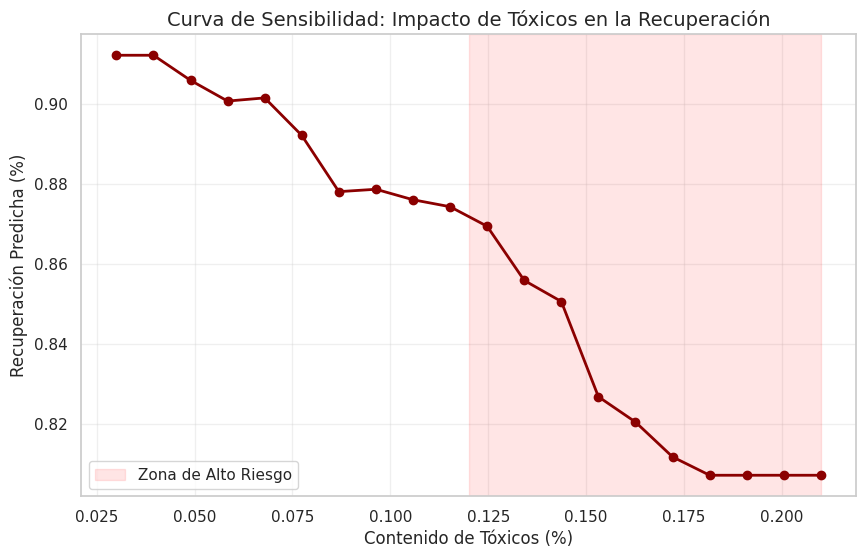

    Tox_Pct  Rec_Estimada
0  0.030000      0.912046
1  0.039474      0.912046
2  0.048947      0.905785
3  0.058421      0.900613
4  0.067895      0.901404
5  0.077368      0.892050
6  0.086842      0.878009
7  0.096316      0.878606
8  0.105789      0.875990
9  0.115263      0.874247


In [21]:
## ANEXO 1: sensibilidad de toxicos en la recuperacion de Cu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generar_tabla_sensibilidad():
    # 1. Cargar modelo
    data_modelo = joblib.load('modelo_final_metalurgia.pkl')
    modelo = data_modelo['modelo']
    features = data_modelo['features']

    # 2. Definir valores "promedio" para las otras variables (Ceteris Paribus)
    # Usamos las medias que calculamos en el describe() anterior
    valores_base = {
        'Ley_Pct': 0.0074,
        'Molido_Kt': 143.0,
        'PctFinos': 0.31,
        'Stock_Pile_Pct': 0.72
    }

    # 3. Crear rango de Tóxicos (de 0.03% a 0.21% según tu min/max)
    rango_tox = np.linspace(0.03, 0.21, 20)

    resultados = []
    for t in rango_tox:
        # Crear fila para el modelo
        fila = pd.DataFrame([[valores_base['Ley_Pct'], t, valores_base['Molido_Kt'],
                             valores_base['PctFinos'], valores_base['Stock_Pile_Pct']]],
                            columns=features)
        pred = modelo.predict(fila)[0]
        resultados.append({'Tox_Pct': t, 'Rec_Estimada': pred})

    df_sensibilidad = pd.DataFrame(resultados)

    # 4. Graficar la curva de sensibilidad
    plt.figure(figsize=(10, 6))
    plt.plot(df_sensibilidad['Tox_Pct'], df_sensibilidad['Rec_Estimada'],
             color='darkred', marker='o', linewidth=2)

    plt.title('Curva de Sensibilidad: Impacto de Tóxicos en la Recuperación', fontsize=14)
    plt.xlabel('Contenido de Tóxicos (%)')
    plt.ylabel('Recuperación Predicha (%)')
    plt.grid(True, alpha=0.3)

    # Añadir línea de umbral crítico visual (donde la pendiente cae más fuerte)
    plt.axvspan(0.12, 0.21, color='red', alpha=0.1, label='Zona de Alto Riesgo')
    plt.legend()
    plt.show()

    return df_sensibilidad

# Ejecutar y mostrar tabla
tabla = generar_tabla_sensibilidad()
print(tabla.head(10)) # Muestra los primeros 10 escenarios

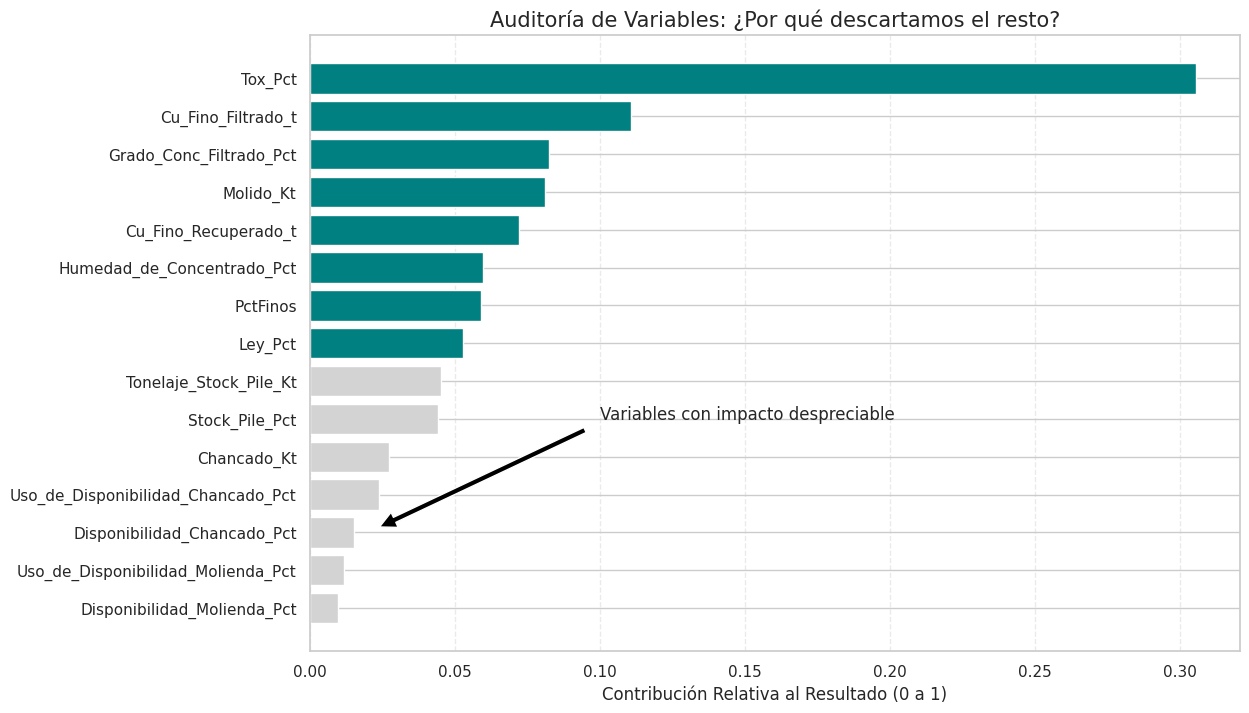

In [23]:
## ANEXO 2: Variables de importancia
# 1. Definimos la lista completa de variables del dataset (todas las numéricas)
todas_las_features = [
    'Chancado_Kt', 'Molido_Kt', 'Ley_Pct', 'Tox_Pct', 'Cu_Fino_Recuperado_t',
    'Cu_Fino_Filtrado_t', 'Grado_Conc_Filtrado_Pct', 'PctFinos', 'Stock_Pile_Pct',
    'Tonelaje_Stock_Pile_Kt', 'Humedad_de_Concentrado_Pct', 'Disponibilidad_Chancado_Pct',
    'Uso_de_Disponibilidad_Chancado_Pct', 'Disponibilidad_Molienda_Pct',
    'Uso_de_Disponibilidad_Molienda_Pct'
]

# 2. Preparamos los datos
X_todas = df_limpio[todas_las_features]
y_target = df_limpio['Rec_Pct']

# 3. Entrenamos un modelo "Global"
modelo_global = RandomForestRegressor(n_estimators=300, random_state=42)
modelo_global.fit(X_todas, y_target)

# 4. Graficamos la importancia de ABSOLUTAMENTE TODO
importancias_globales = modelo_global.feature_importances_
df_imp_global = pd.DataFrame({
    'Variable': todas_las_features,
    'Importancia': importancias_globales
}).sort_values('Importancia', ascending=True)

plt.figure(figsize=(12, 8))
colors = ['lightgrey' if val < 0.05 else 'teal' for val in df_imp_global['Importancia']]
plt.barh(df_imp_global['Variable'], df_imp_global['Importancia'], color=colors)

plt.title('Auditoría de Variables: ¿Por qué descartamos el resto?', fontsize=15)
plt.xlabel('Contribución Relativa al Resultado (0 a 1)')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Añadimos nota explicativa para el gerente
plt.annotate('Variables con impacto despreciable', xy=(0.02, 2), xytext=(0.1, 5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

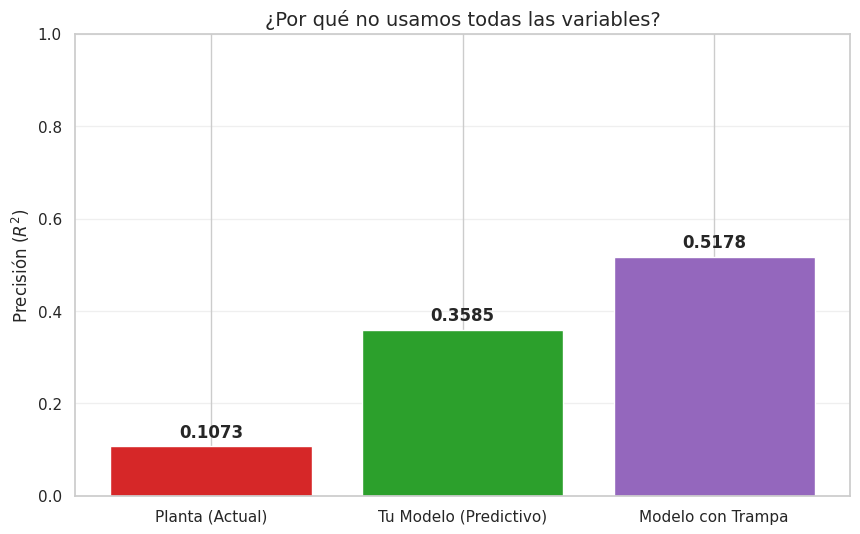

In [25]:
from sklearn.model_selection import train_test_split

# 1. Definir los dos grupos de variables
features_predictivas = ['Tox_Pct', 'Molido_Kt', 'PctFinos', 'Ley_Pct', 'Stock_Pile_Pct']
features_trampa = [
    'Chancado_Kt', 'Molido_Kt', 'Ley_Pct', 'Tox_Pct', 'Cu_Fino_Recuperado_t',
    'Cu_Fino_Filtrado_t', 'Grado_Conc_Filtrado_Pct', 'PctFinos', 'Stock_Pile_Pct',
    'Tonelaje_Stock_Pile_Kt', 'Humedad_de_Concentrado_Pct', 'Disponibilidad_Chancado_Pct',
    'Uso_de_Disponibilidad_Chancado_Pct', 'Disponibilidad_Molienda_Pct',
    'Uso_de_Disponibilidad_Molienda_Pct'
]

# 2. REHACER el split con el DataFrame completo (df_limpio)
# Esto asegura que X_train_full tenga TODAS las columnas
X_full = df_limpio[features_trampa]
y_full = df_limpio['Rec_Pct']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# 3. Entrenar Modelo Real (Solo predictivas)
modelo_real = RandomForestRegressor(n_estimators=300, random_state=42)
modelo_real.fit(X_train_f[features_predictivas], y_train_f)
r2_real = r2_score(y_test_f, modelo_real.predict(X_test_f[features_predictivas]))

# 4. Entrenar Modelo con Trampa (Todas las variables)
modelo_trampa = RandomForestRegressor(n_estimators=300, random_state=42)
modelo_trampa.fit(X_train_f, y_train_f)
r2_trampa = r2_score(y_test_f, modelo_trampa.predict(X_test_f))

# 5. Graficar la comparativa final
plt.figure(figsize=(10, 6))
modelos = ['Planta (Actual)', 'Tu Modelo (Predictivo)', 'Modelo con Trampa']
# El 0.1073 es el valor que obtuviste en tu gráfico anterior para la planta
valores_r2 = [0.1073, r2_real, r2_trampa]

bars = plt.bar(modelos, valores_r2, color=['#d62728', '#2ca02c', '#9467bd'])
plt.ylim(0, 1.0)
plt.title('¿Por qué no usamos todas las variables?', fontsize=14)
plt.ylabel('Precisión ($R^2$)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()

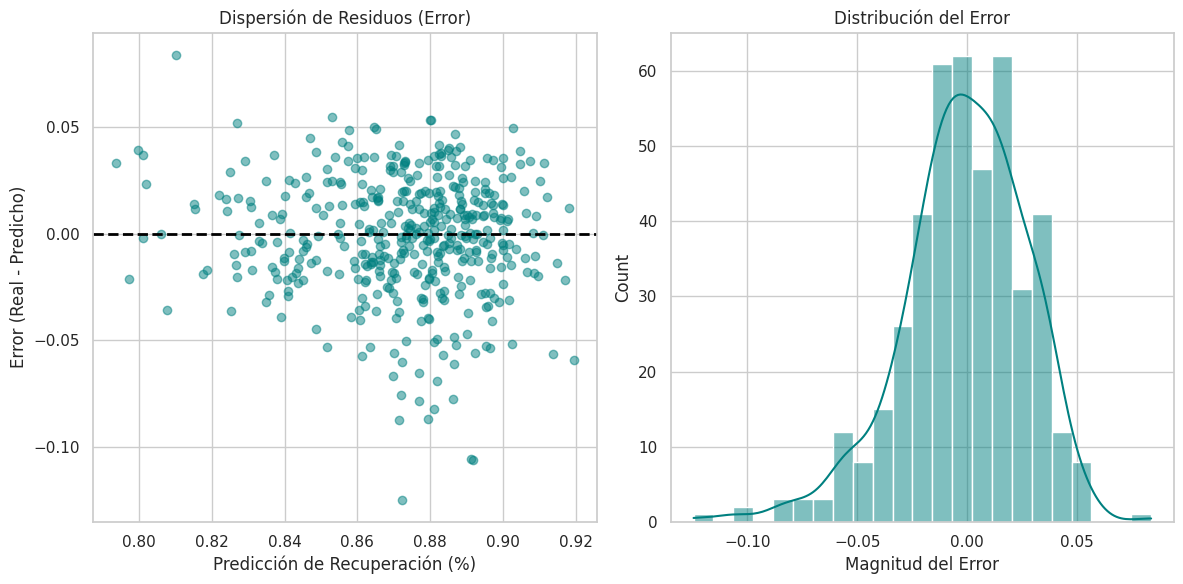

Error Promedio del Modelo: 0.0218 (% de recuperación)


In [26]:
## analisis de residuos del modelo de ML
# 1. Calcular los residuos (Diferencia entre Real y Predicho)
residuos = y_test_f - modelo_real.predict(X_test_f[features_predictivas])

# 2. Graficar
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(modelo_real.predict(X_test_f[features_predictivas]), residuos, alpha=0.5, color='teal')
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.title('Dispersión de Residuos (Error)')
plt.xlabel('Predicción de Recuperación (%)')
plt.ylabel('Error (Real - Predicho)')

plt.subplot(1, 2, 2)
sns.histplot(residuos, kde=True, color='teal')
plt.title('Distribución del Error')
plt.xlabel('Magnitud del Error')

plt.tight_layout()
plt.show()

# Calcular el MAE (Error Absoluto Medio) para decírselo al gerente
mae_final = mean_absolute_error(y_test_f, modelo_real.predict(X_test_f[features_predictivas]))
print(f"Error Promedio del Modelo: {mae_final:.4f} (% de recuperación)")

In [27]:
import joblib

# Guardamos el modelo y los nombres de las columnas para que no haya errores
data_para_exportar = {
    'modelo': modelo_real,
    'features': ['Tox_Pct', 'Molido_Kt', 'PctFinos', 'Ley_Pct', 'Stock_Pile_Pct'],
    'factor_ajuste': -0.01  # El factor de seguridad que sugerimos por el sesgo
}

joblib.dump(data_para_exportar, 'modelo_predictivo_recuperacion.pkl')

['modelo_predictivo_recuperacion.pkl']

In [28]:
def predecir_mañana(datos_plan):
    # 1. Cargar cerebro
    paquete = joblib.load('modelo_predictivo_recuperacion.pkl')

    # 2. Convertir plan a DataFrame
    df_mañana = pd.DataFrame([datos_plan], columns=paquete['features'])

    # 3. Predecir y aplicar factor de seguridad
    prediccion_base = paquete['modelo'].predict(df_mañana)[0]
    prediccion_ajustada = prediccion_base + paquete['factor_ajuste']

    return prediccion_ajustada

# Ejemplo: Datos del plan de mañana
plan_lunes = {
    'Tox_Pct': 0.14,      # Alto tóxico esperado
    'Molido_Kt': 145.0,
    'PctFinos': 0.32,
    'Ley_Pct': 0.0075,
    'Stock_Pile_Pct': 0.85
}

print(f"Recuperación esperada para mañana: {predecir_mañana(plan_lunes):.2%}")

Recuperación esperada para mañana: 83.02%


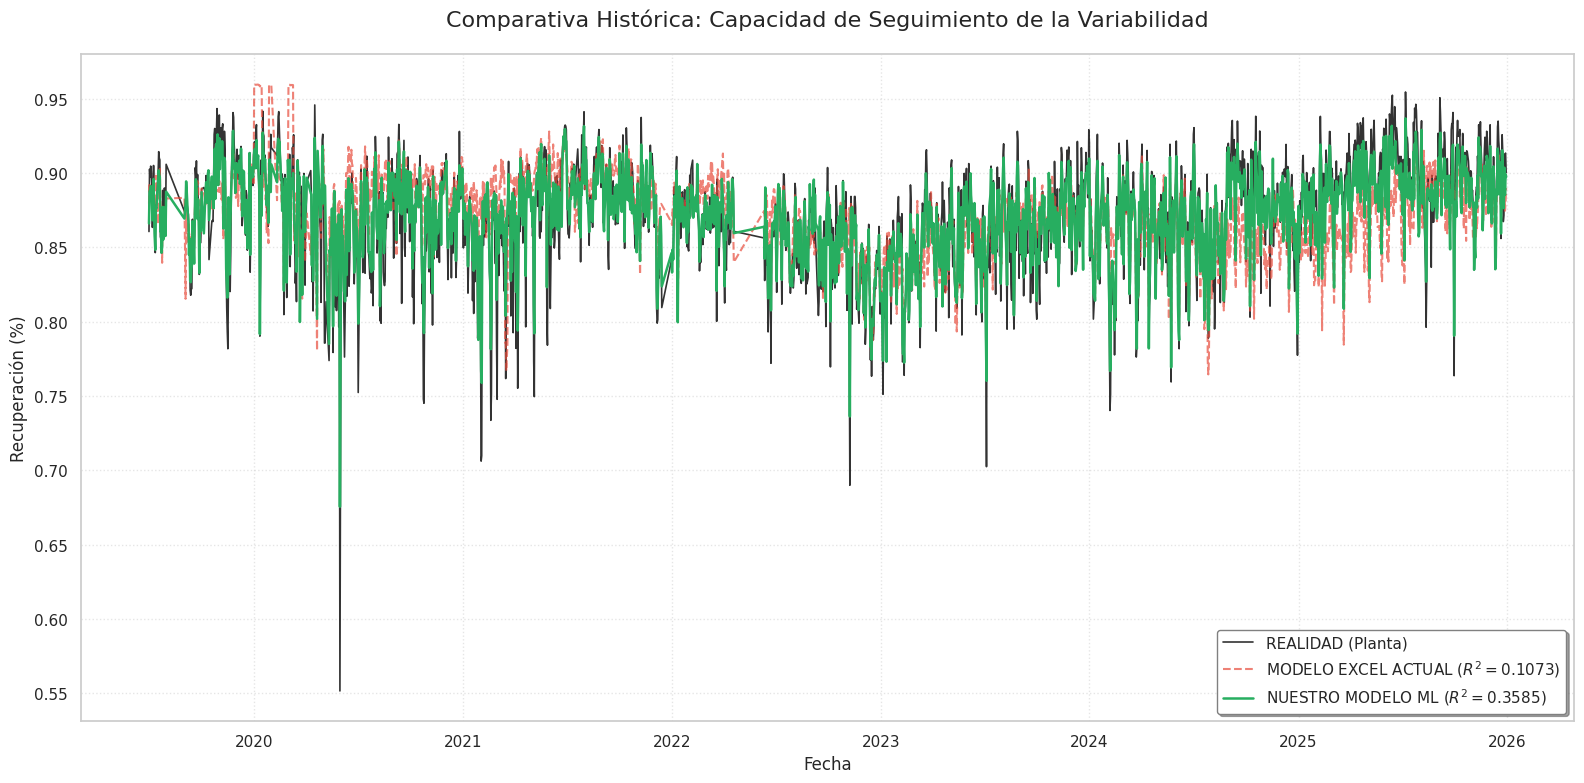

In [40]:
## comparativa historica
import matplotlib.pyplot as plt

def graficar_presentacion_gerencial(df_limpio, modelo_ml, features_ml):
    # 1. Preparar datos y predicción
    df_plot = df_limpio.copy().sort_values('Fecha')
    df_plot['Prediccion_ML'] = modelo_ml.predict(df_plot[features_ml])

    # 2. Configurar el lienzo
    plt.figure(figsize=(16, 8))

    # REALIDAD - Negro con transparencia (se percibe como gris oscuro de fondo)
    plt.plot(df_plot['Fecha'], df_plot['Rec_Pct'],
             label='REALIDAD (Planta)', color='black', linewidth=1.2, alpha=0.8)

    # MODELO EXCEL ACTUAL - Rojo discontinuo (el sistema a reemplazar)
    plt.plot(df_plot['Fecha'], df_plot['Rec_Modelo_Pct'],
             label='MODELO EXCEL ACTUAL ($R^2=0.1073$)', color='#e74c3c',
             linestyle='--', linewidth=1.5, alpha=0.7)

    # NUESTRO MODELO ML - Verde sólido y grueso (la propuesta de valor)
    plt.plot(df_plot['Fecha'], df_plot['Prediccion_ML'],
             label='NUESTRO MODELO ML ($R^2=0.3585$)', color='#27ae60',
             linewidth=1.8)

    # 3. Estética y Ubicación de Leyenda
    plt.title('Comparativa Histórica: Capacidad de Seguimiento de la Variabilidad', fontsize=16, pad=20)
    plt.ylabel('Recuperación (%)', fontsize=12)
    plt.xlabel('Fecha', fontsize=12)

    # Leyenda en la esquina inferior derecha para no tapar los datos
    plt.legend(loc='lower right', frameon=True, shadow=True,
               facecolor='white', edgecolor='gray', fontsize=11)

    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Ejecución
graficar_presentacion_gerencial(df_limpio, modelo_real, features_predictivas)

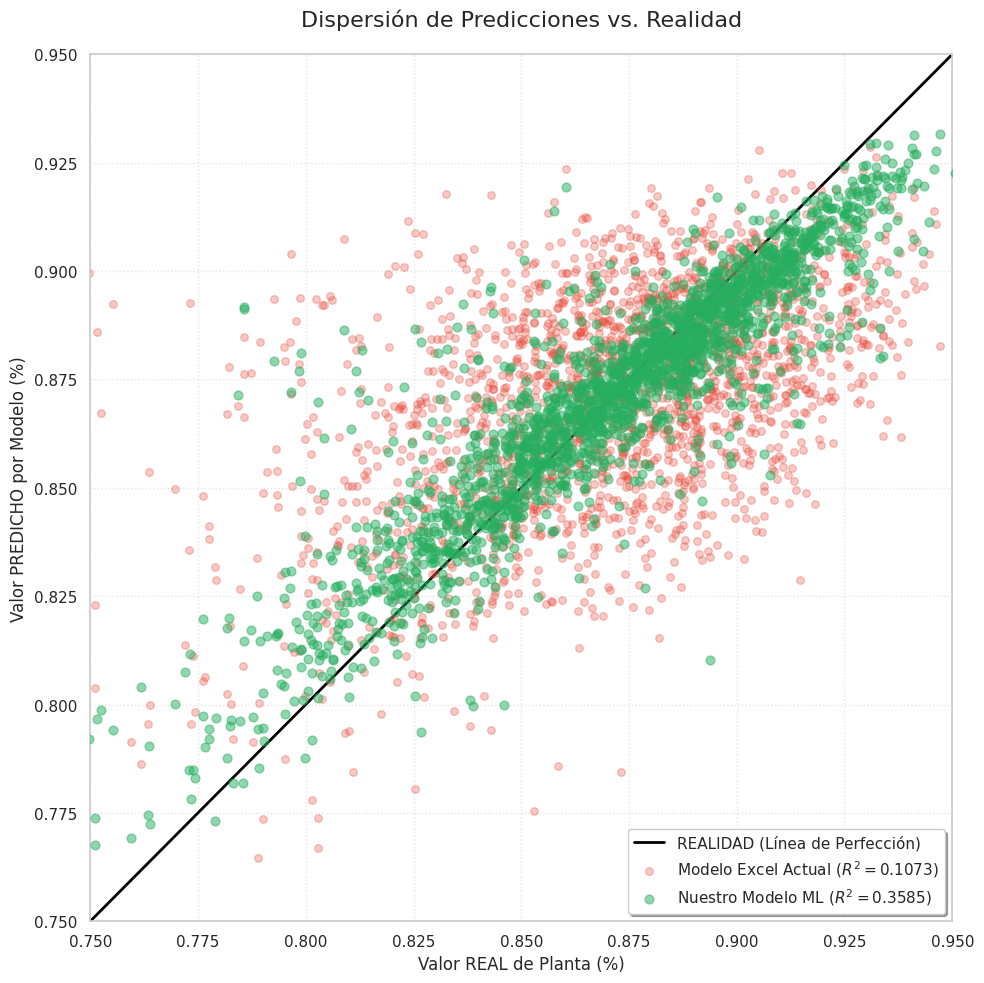

In [41]:
## scatterplot comparativo
import matplotlib.pyplot as plt

def graficar_scatter_final(df_limpio, modelo_ml, features_ml):
    # 1. Datos
    y_real = df_limpio['Rec_Pct']
    y_pred_ml = modelo_ml.predict(df_limpio[features_ml])
    y_pred_excel = df_limpio['Rec_Modelo_Pct']

    # 2. Configuración
    plt.figure(figsize=(10, 10))

    # Rango para la línea de perfección
    min_val, max_val = 0.75, 0.95

    # LÍNEA DE PERFECCIÓN (La meta)
    plt.plot([min_val, max_val], [min_val, max_val], color='black',
             linestyle='-', linewidth=2, label='REALIDAD (Línea de Perfección)', zorder=1)

    # Puntos Modelo Excel (Rojo) - Se ven más dispersos
    plt.scatter(y_real, y_pred_excel, color='#e74c3c', alpha=0.3, s=30,
                label=f'Modelo Excel Actual ($R^2=0.1073$)', zorder=2)

    # Puntos Nuestro Modelo ML (Verde) - Se ven más agrupados a la línea
    plt.scatter(y_real, y_pred_ml, color='#27ae60', alpha=0.5, s=40,
                label=f'Nuestro Modelo ML ($R^2=0.3585$)', zorder=3)

    # 3. Estética y Ubicación de Leyenda
    plt.title('Dispersión de Predicciones vs. Realidad', fontsize=16, pad=20)
    plt.xlabel('Valor REAL de Planta (%)', fontsize=12)
    plt.ylabel('Valor PREDICHO por Modelo (%)', fontsize=12)

    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    # Leyenda abajo a la derecha
    plt.legend(loc='lower right', frameon=True, shadow=True, facecolor='white', fontsize=11)

    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Ejecución
graficar_scatter_final(df_limpio, modelo_real, features_predictivas)

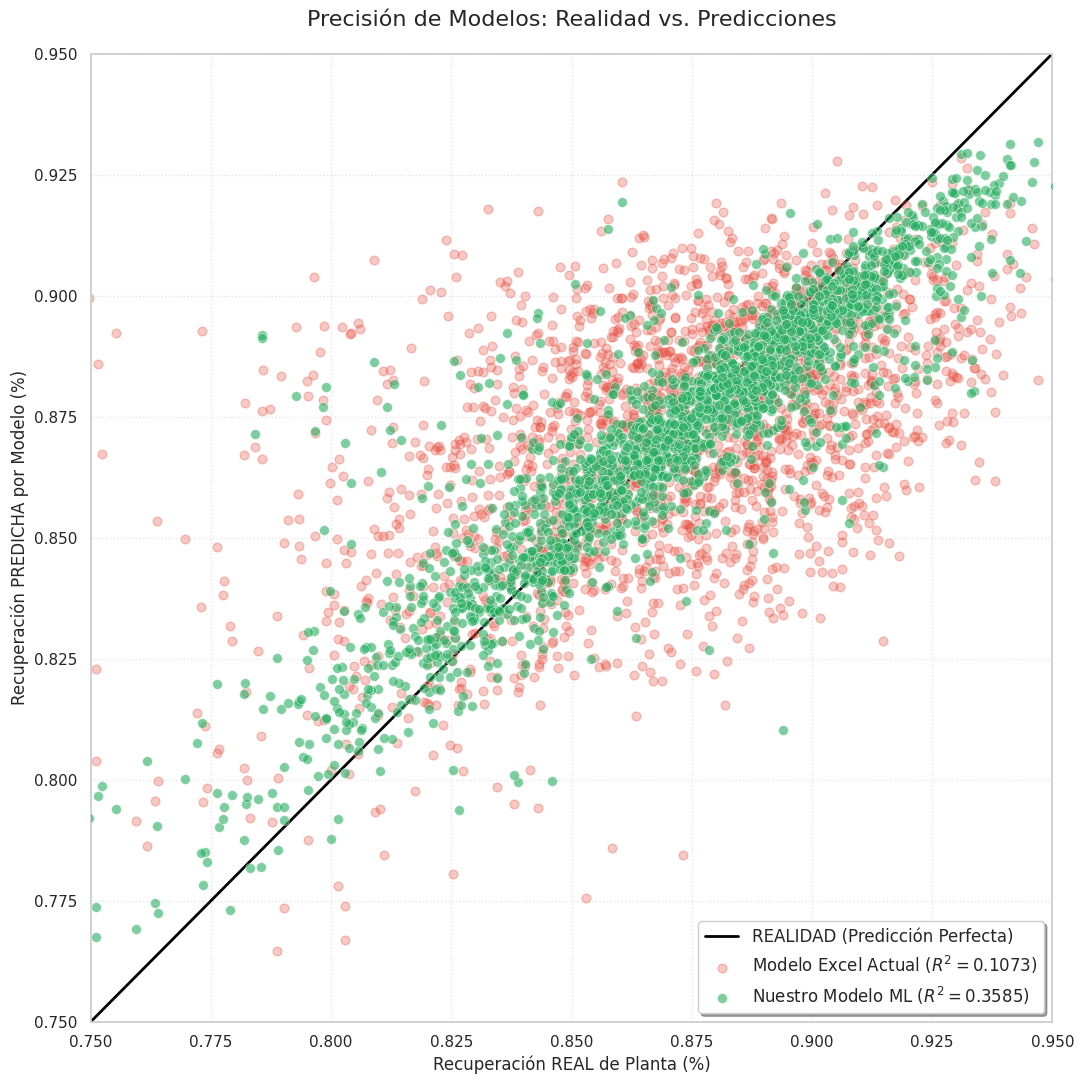

In [42]:
## otro scatterplot comparativo
import matplotlib.pyplot as plt

def graficar_scatter_gerencial(df_limpio, modelo_ml, features_ml):
    # 1. Preparar datos
    y_real = df_limpio['Rec_Pct']
    y_pred_ml = modelo_ml.predict(df_limpio[features_ml])
    y_pred_excel = df_limpio['Rec_Modelo_Pct']

    # 2. Configuración del lienzo
    plt.figure(figsize=(11, 11))

    # Definir límites basados en tus datos (75% a 95% de recuperación)
    limite_min, limite_max = 0.75, 0.95

    # LÍNEA DE PERFECCIÓN (El objetivo ideal)
    plt.plot([limite_min, limite_max], [limite_min, limite_max],
             color='black', linestyle='-', linewidth=2, label='REALIDAD (Predicción Perfecta)', zorder=1)

    # MODELO EXCEL (Rojo) - Se grafica primero para que quede atrás
    plt.scatter(y_real, y_pred_excel, color='#e74c3c', alpha=0.3, s=40,
                label=f'Modelo Excel Actual ($R^2=0.1073$)', zorder=2)

    # NUESTRO MODELO ML (Verde) - Se grafica encima para resaltar el agrupamiento
    plt.scatter(y_real, y_pred_ml, color='#27ae60', alpha=0.6, s=50,
                edgecolors='white', linewidth=0.5,
                label=f'Nuestro Modelo ML ($R^2=0.3585$)', zorder=3)

    # 3. Detalles estéticos
    plt.title('Precisión de Modelos: Realidad vs. Predicciones', fontsize=16, pad=20)
    plt.xlabel('Recuperación REAL de Planta (%)', fontsize=12)
    plt.ylabel('Recuperación PREDICHA por Modelo (%)', fontsize=12)

    plt.xlim(limite_min, limite_max)
    plt.ylim(limite_min, limite_max)

    # Leyenda en la esquina inferior derecha
    plt.legend(loc='lower right', frameon=True, shadow=True, facecolor='white', fontsize=12)

    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Ejecutar el gráfico
graficar_scatter_gerencial(df_limpio, modelo_real, features_predictivas)